In [2]:
%matplotlib inline
import numpy as np
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import pandas as pd
import dask
import sh
import os.path
from __future__ import division
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.rcParams['contour.negative_linestyle']= 'dashed'
plt.rcParams['image.cmap'] = 'RdBu'

from progress_bar import *
from useful import *
from plotting import *

global data_dir
data_dir = '/scratch/ap587/dry_data/'

plot_dir = '/scratch/ap587/plots/paper1/'
mkdir = sh.mkdir.bake('-p')
mkdir(plot_dir)

/scratch/ap587/envs/ipyserv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [38]:
def plot_twocol(exps, season=None, do_eddy=True):
    
    season_array = [np.arange(8,26), np.arange(26,44), np.arange(44,62), np.append(np.arange(0,8),np.arange(62,72))]
    tlev = np.arange(180, 310, 15)
    psilev = np.array([-24e10, -15e10, -12e10, -9e10, -6e10, -5e10, -4e10, -3e10, -2e10, -1e10, -0.5e10, 0.5e10,
                       1e10, 2e10, 3e10, 4e10,5e10, 6e10, 9e10, 12e10, 15e10, 24e10])
    ulev = np.arange(-105, 106, 10)
    uvlev = np.linspace(-9e6,9e6,20)
    
    fig, axes = plt.subplots(len(exps), 2, figsize=(12, 4*len(exps)))        
    for i, exp in enumerate(exps):
        ds = open_climatology(data_dir, exp)
        if season == None:
            dss = ds.mean('pentad')
        else:
            dss = ds.isel(pentad=season_array[season]).mean('pentad')
            
        x = dss.lat.values
        y = dss.pfull.values    
        X, Y = np.meshgrid(x, y)
        
        axes[i,0].contour(X, Y, dss.ucomp, ulev, add_colorbar=False, robust=True, colors='k')
        dss.temp.plot.contourf(x='lat', y='pfull', ax=axes[i,0], robust=True,
                               extend='both', add_colorbar=False, levels=tlev)
        axes[i,0].invert_yaxis()
        axes[i,0].set_xlabel('Latitude')
        axes[i,0].set_ylabel('Pressure')
        
        
        dss.psi.plot.contourf(x='lat', y='pfull', ax=axes[i,1], levels=psilev, extend='both')
        if do_eddy:
            axes[i,1].contour(X, Y, dss.uv, add_colorbar=False, robust=True,  colors='k', levels=uvlev)
        axes[i,1].invert_yaxis()
        axes[i,1].set_xlabel('Latitude')
        axes[i,1].set_ylabel('Pressure')
        

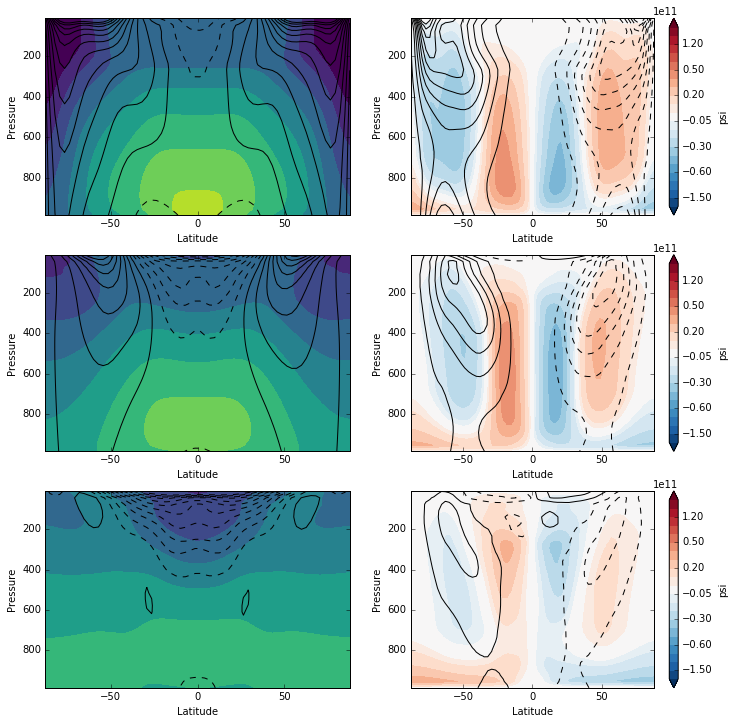

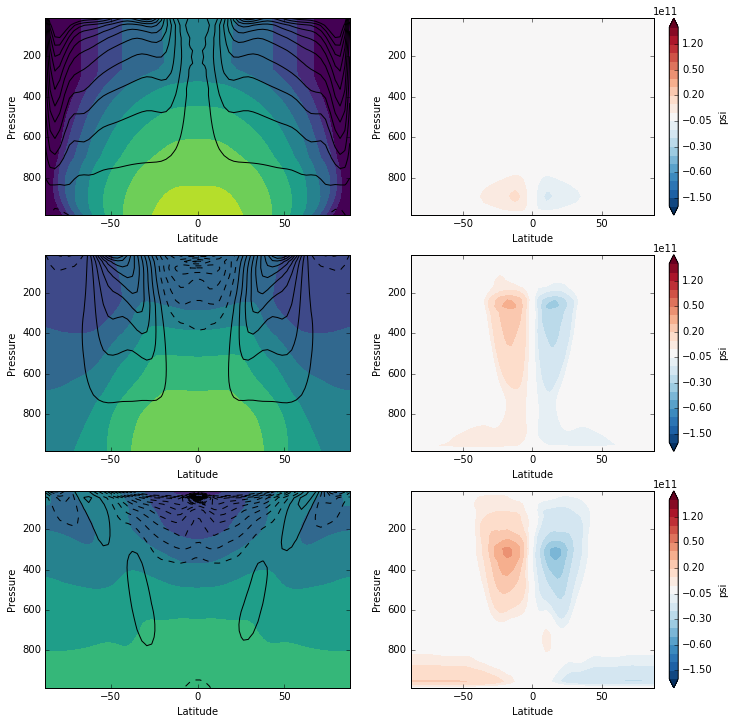

In [39]:
# --- Fig 1. Annual Mean 3D obliquity variation at MLD 10m ---
#data_dir = '/scratch/ap587/gfdl_data/'
obls = np.arange(0, 90, 30)
hcs = [10]
for hc in hcs:
    exps = []
    for obl in obls:
        exps.append('exp9v2_hc{:.1f}-obl{:.1f}'.format(hc,obl))
        #exps.append('frierson_hc{}-obl{}'.format(hc,obl))
        
    plot_twocol(exps, season=None)

    savename = 'annual_mean_hc%d' % hc
    plt.savefig(plot_dir + savename + '.png', dpi=200,bbox_inches='tight',transparent=False)
    plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)


exps = []
for hc in hcs:
    for obl in obls:
        exps.append('exp9v1_hc{:.1f}-obl{:.1f}'.format(hc,obl))
        #exps.append('frierson-axi_obl{}'.format(obl))
        
    plot_twocol(exps, season=None, do_eddy=False)

    savename = 'annual_mean_axi_hc%d' % hc
    plt.savefig(plot_dir + savename + '.png', dpi=200,bbox_inches='tight',transparent=False)
    plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)

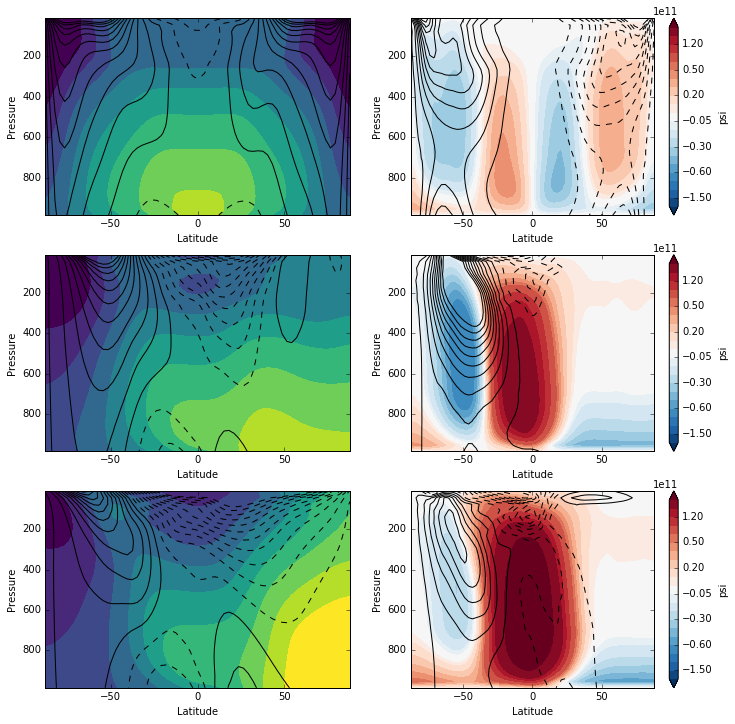

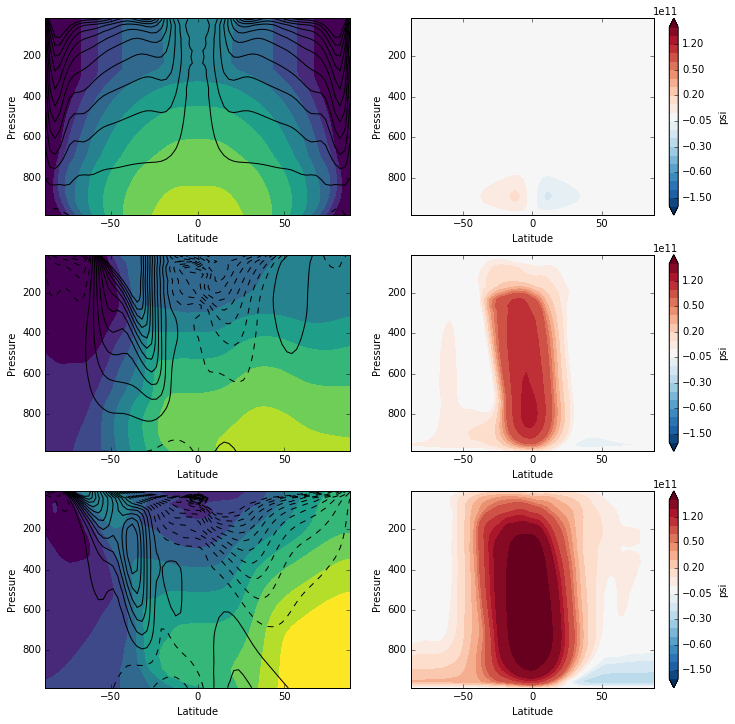

In [40]:
# --- Fig 2. Solstice 3D obliquity variation at MLD 10m ---

obls = np.arange(0, 90, 30)
hcs = [10]
for hc in hcs:
    exps = []
    for obl in obls:
        exps.append('exp9v2_hc{:.1f}-obl{:.1f}'.format(hc,obl))
        #exps.append('frierson_hc{}-obl{}'.format(hc,obl))
        
    plot_twocol(exps, season=1)

    savename = 'solstice_mean_hc%d' % hc
    plt.savefig(plot_dir + savename + '.png', dpi=200,bbox_inches='tight',transparent=False)
    plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)


for hc in hcs:
    exps = []
    for obl in obls:
        exps.append('exp9v1_hc{:.1f}-obl{:.1f}'.format(hc,obl))
        #exps.append('frierson-axi_obl{}'.format(obl))
        
    plot_twocol(exps, season=1, do_eddy=False)
    
    savename = 'solstice_mean_axi_hc%d' % hc
    plt.savefig(plot_dir + savename + '.png', dpi=200,bbox_inches='tight',transparent=False)
    plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)

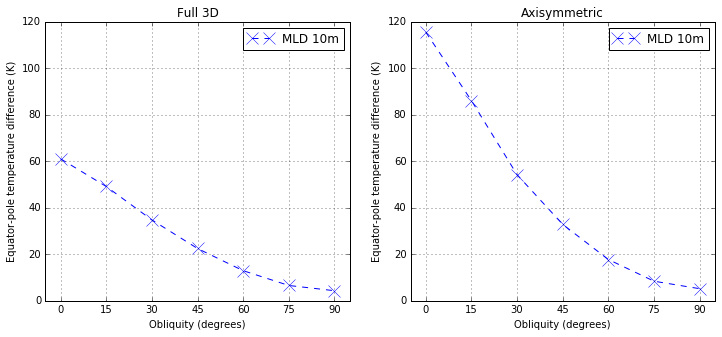

In [27]:
# --- Fig 3. Equator-pole temperature differences ---

hcs = [10]
obls = np.arange(0,91,15)

eqpole_t = np.zeros((len(hcs),len(obls))) * np.nan
axi_eqpole_t = np.zeros((len(hcs),len(obls))) * np.nan

for i in range(len(hcs)):
    for j in range(len(obls)):
        try:
            ds = open_climatology(data_dir, 'exp9v2_hc{:.1f}-obl{:.1f}'.format(hcs[i], obls[j]))
            ds_axi = open_climatology(data_dir, 'exp9v1_hc{:.1f}-obl{:.1f}'.format(hcs[i], obls[j]))
            #ds = open_climatology('/scratch/ap587/gfdl_data/', 'frierson_hc{}-obl{}'.format(hcs[i], obls[j]))
            #ds_axi = open_climatology('/scratch/ap587/gfdl_data/', 'frierson-axi_obl{}'.format(obls[j]))
        except:
            print('ERROR: Did not find ' + 'hc{:.1f}-obl{:.1f}'.format(hcs[i], obls[j]))
            break
        ds_mean = ds.mean('pentad')
        ds_axi_mean = ds_axi.mean('pentad')
        eqpole_t[i,j] = (ds_mean.temp.isel(lat=slice(31,33), pfull=-1).mean('lat') - 
                               ds_mean.temp.isel(lat=slice(0,2), pfull=-1).mean('lat'))
        axi_eqpole_t[i,j] = (ds_axi_mean.temp.isel(lat=slice(31,33), pfull=-1).mean('lat') - 
                               ds_axi_mean.temp.isel(lat=slice(0,2), pfull=-1).mean('lat'))


colors = ['b', 'r', 'g']
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
for i in range(len(hcs)):
    axes[0].plot(obls, eqpole_t[i,:], 'x', color=colors[i], linestyle='--', markersize=12, label='MLD {}m'.format(hcs[i]))
    axes[1].plot(obls, axi_eqpole_t[i,:], 'x', color=colors[i], linestyle='--', markersize=12, label='MLD {}m'.format(hcs[i]))    
for i in range(2):
    axes[i].legend()
    axes[i].grid()
    axes[i].set_xlim([-5,95])
    axes[i].set_xticks(obls)
    axes[i].set_xlabel('Obliquity (degrees)')
    axes[i].set_ylabel('Equator-pole temperature difference (K)')   
for tk in axes[1].get_yticklabels():
    tk.set_visible(True)
    
axes[0].set_title('Full 3D')
axes[1].set_title('Axisymmetric')

savename = 'eq-pole_temp'
plt.savefig(plot_dir + savename + '.png', dpi=200,bbox_inches='tight',transparent=False)
plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)

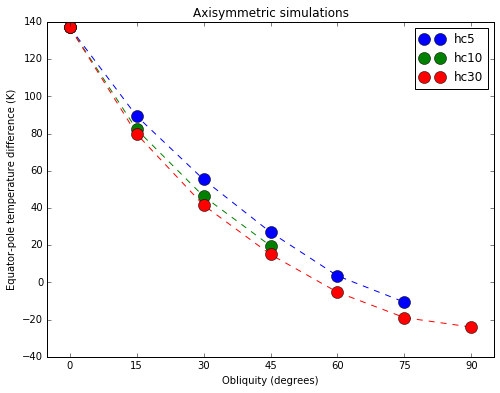

In [23]:
# --- Fig 4. Axisymmetric equator-pole temperature differences ---

hcs = [5, 10, 30]
obls = np.arange(0,91,15)

zmean_eqpole_t = np.zeros((len(hcs),len(obls))) * np.nan

for i in range(len(hcs)):
    for j in range(len(obls)):
        try:
            ds = open_climatology(data_dir, 'exp9v1_hc{:.1f}-obl{:.1f}'.format(hcs[i], obls[j]))
        except:
            break
        ds_mean = ds.mean('pentad')
        zmean_eqpole_t[i,j] = (ds_mean.temp.isel(lat=slice(31,33), pfull=-1).mean('lat') - 
                               ds_mean.temp.isel(lat=slice(0,2), pfull=-1).mean('lat'))

fig, ax = plt.subplots()
for i in range(len(hcs)):
    ax.plot(obls, zmean_eqpole_t[i,:], 'o', linestyle='--', markersize=12, label='hc{}'.format(hcs[i]))
ax.legend()
ax.set_xlim([-5,95])
#ax.set_ylim([-45,45])
ax.set_xticks(obls)
#ax.set_yticks(np.arange(-40,41,20))
ax.set_xlabel('Obliquity (degrees)')
ax.set_ylabel('Equator-pole temperature difference (K)')
ax.set_title('Axisymmetric simulations')

savename = 'eq-pole_temp_axi'
plt.savefig(plot_dir + savename + '.png', dpi=200,bbox_inches='tight',transparent=False)
plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)

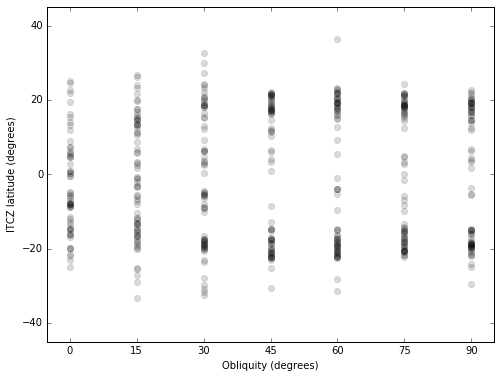

In [16]:
# --- Fig 5. Pentad mean ITCZ latitudes ---

hcs = [10]
obls = np.arange(0,91,15)

itcz_lat = np.zeros((len(hcs),len(obls),72)) * np.nan

for i in range(len(hcs)):
    for j in range(len(obls)):
        try:
            filen = 'frierson-axi_obl{}'.format(obls[j])
            ds = open_climatology(data_dir, 'exp9v1_hc{:.1f}-obl{:.1f}'.format(hcs[i], obls[j]))
            #ds = open_climatology('/scratch/ap587/gfdl_data/', filen)
        except:
            print('Error opening file ' + filen)
            break
        for k in range(len(ds.pentad)):
            dss = ds.isel(pentad=k)
            itcz_lat[i,j,k] = calc_itcz_lat(dss)
            
fig, ax = plt.subplots()
for i in range(72):
    ax.plot(obls, itcz_lat[0,:,i], 'k.', alpha=0.15, markersize=13)
ax.set_xlim([-5,95])
ax.set_ylim([-45,45])
ax.set_xticks(obls)
ax.set_yticks(np.arange(-40,41,20))
ax.set_xlabel('Obliquity (degrees)')
ax.set_ylabel('ITCZ latitude (degrees)')

savename = 'ITCZ_lats_hc%d' % hcs[0]
plt.savefig(plot_dir + savename + '.png', dpi=200,bbox_inches='tight',transparent=False)
plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)

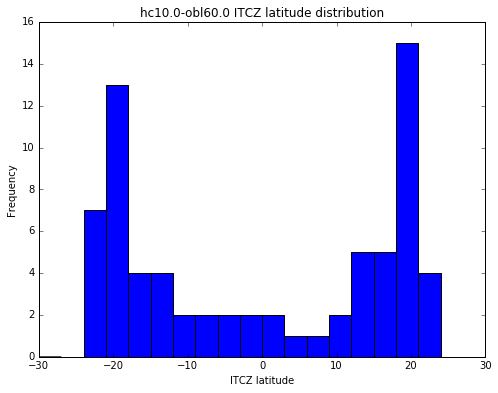

In [8]:
# --- Fig 6. ITCZ latitude probability density function ---

hc = 10
obl = 60
exp = 'exp9v2_hc{:.1f}-obl{:.1f}'.format(hc, obl)

ds = open_climatology(data_dir, exp)
itcz_lat = np.zeros(len(ds.pentad))
for k in range(len(ds.pentad)):
    itcz_lat[k] = calc_itcz_lat(ds.isel(pentad=k))
    

fig, ax = plt.subplots()
plt.hist(itcz_lat, bins=20, range=(-30,30))
plt.xlabel('ITCZ latitude')
plt.ylabel('Frequency')
plt.title(exp[7:] + ' ITCZ latitude distribution')

/scratch/ap587/envs/ipyserv/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


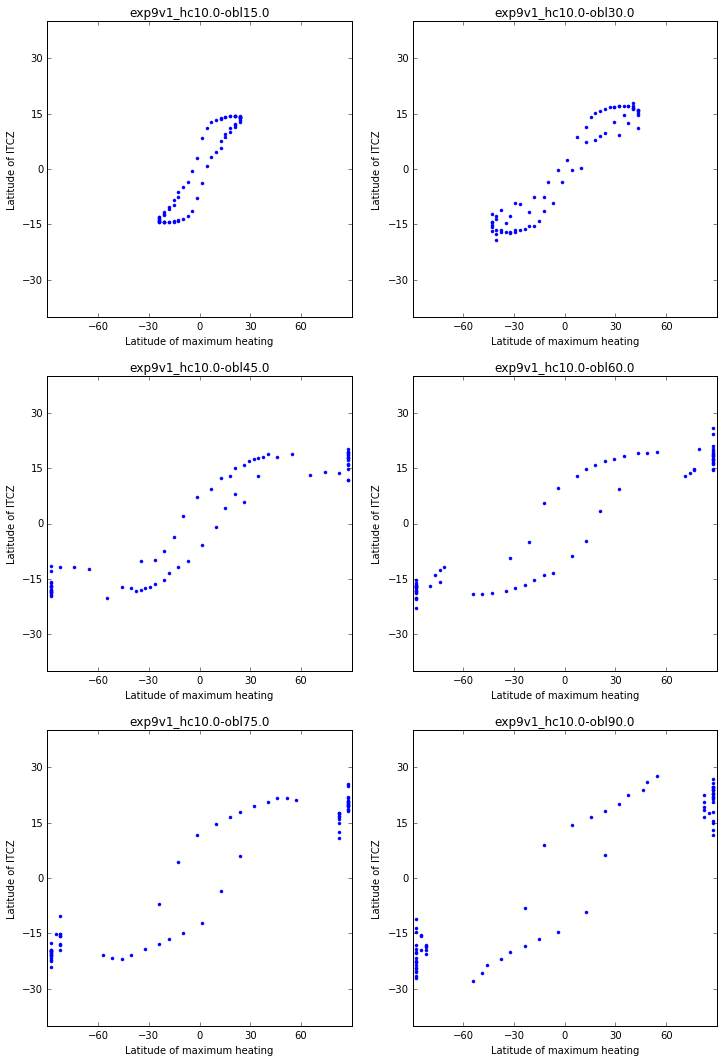

In [65]:
# --- Fig 6b. Peak temperature lat vs ITCZ lat  ---

hc = 10
obls = np.arange(15,91,15)
#obls = [30,30,60,60]
#yls = [1,5,1,5]
    
fig, axes = plt.subplots(len(obls)//2, 2, figsize=(12,3*len(obls)))

for i, obl in enumerate(obls):
    #exp = 'topdown_hc10_yl{}-obl{}'.format(yls[i],obl)
    #ds = open_climatology('/scratch/ap587/gfdl_data/', exp)
    exp = 'exp9v1_hc{:.1f}-obl{:.1f}'.format(hc, obl)
    ds = open_climatology(data_dir, exp)
    itcz_lat = np.zeros(len(ds.pentad))
    peak_t_lat = np.zeros(len(ds.pentad))
    for k in range(len(ds.pentad)):
        itcz_lat[k] = calc_itcz_lat(ds.isel(pentad=k))
        peak_t_lat[k] = ds.lat.values[np.argmax(ds.temp.isel(pentad=k, pfull=-1))]
    
    ax = axes[i//2,i%2]
    ax.plot(peak_t_lat, itcz_lat, '.')
    ax.set_xlim([-90,90])
    ax.set_ylim([-40,40])
    ax.set_xticks(np.arange(-60,61,30))
    ax.set_yticks(np.arange(-30,31,15))
    ax.set_title(exp)
    ax.set_xlabel('Latitude of maximum heating')
    ax.set_ylabel('Latitude of ITCZ')

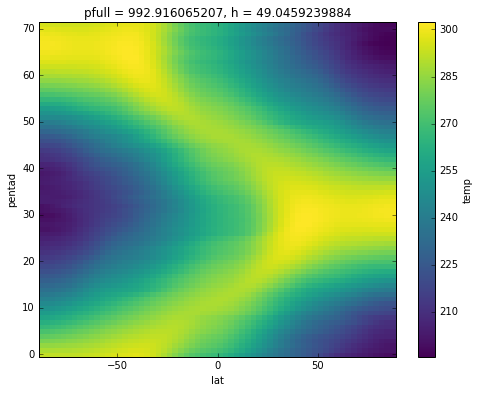

In [61]:

exp = 'topdown_hc10_yl{}-obl{}'.format(1,30)
ds = open_climatology('/scratch/ap587/gfdl_data/', exp)

ds.temp.isel(pfull=-1).plot()

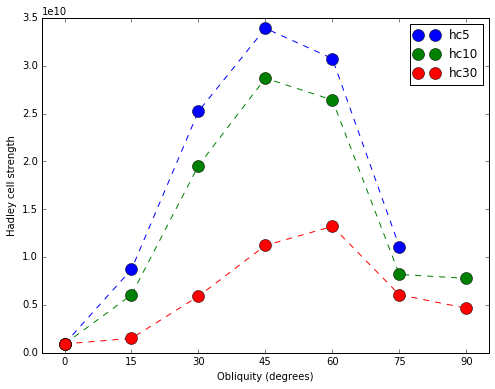

In [19]:
# --- Fig 7. Annual mean Hadley cell strength ---

# --- ITCZ latitude ---

hcs = [5, 10, 30]
obls = np.arange(0,91,15)

zmean_hc_str = np.zeros((len(hcs),len(obls))) * np.nan

for i in range(len(hcs)):
    for j in range(len(obls)):
        try:
            ds = open_climatology(data_dir, 'exp9v1_hc{:.2f}-obl{:.1f}'.format(hcs[i], obls[j]))
        except:
            break
        ds_mean = ds.mean('pentad')
        zmean_hc_str[i,j] = calc_hadley_str(ds_mean)
            
fig, ax = plt.subplots()
for i in range(len(hcs)):
    ax.plot(obls, zmean_hc_str[i,:], 'o', linestyle='--', markersize=12, label='hc{}'.format(hcs[i]))
ax.legend()
ax.set_xlim([-5,95])
ax.set_xticks(obls)
ax.set_xlabel('Obliquity (degrees)')
ax.set_ylabel('Hadley cell strength')

savename = 'AM_hadley_str'
plt.savefig(plot_dir + savename + '.png', dpi=200,bbox_inches='tight',transparent=False)
plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)

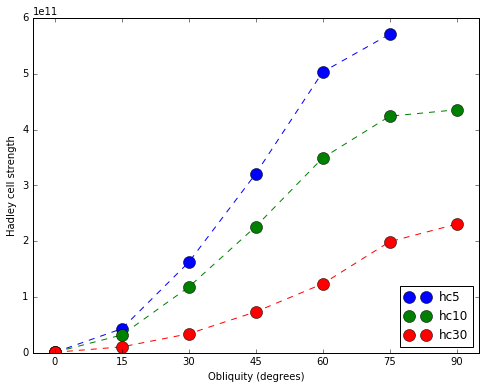

In [21]:
# --- Fig 8. Solstice Hadley cell strength ---

hcs = [5, 10, 30]
obls = np.arange(0,91,15)

sols_hc_str = np.zeros((len(hcs),len(obls),1)) * np.nan

for i in range(len(hcs)):
    for j in range(len(obls)):
        try:
            ds = open_climatology(data_dir, 'exp9v1_hc{:.1f}-obl{:.1f}'.format(hcs[i], obls[j]))
        except:
            break
        ds_sols = ds.isel(pentad=np.arange(26,44)).mean('pentad')
        sols_hc_str[i,j,0] = calc_hadley_str(ds_sols)
        #sols_hc_str[i,j,1] = calc_hadley_str2(ds_sols, do_plot=1)
            
fig, ax = plt.subplots()
for i in range(len(hcs)):
    ax.plot(obls, sols_hc_str[i,:], 'o', linestyle='--', markersize=12, label='hc{}'.format(hcs[i]))
ax.legend(loc=4)
ax.set_xlim([-5,95])
ax.set_xticks(obls)
ax.set_xlabel('Obliquity (degrees)')
ax.set_ylabel('Hadley cell strength')

savename = 'sol_hadley_str_axi'
plt.savefig(plot_dir + savename + '.png', dpi=200,bbox_inches='tight',transparent=False)
plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)